# 3. Clasificación de subtópicos 

* Debido a que existían tópicos los cuales contenían noticias que podríamos asignar a más de una categoría optamos por realizar un segundo LDA.

## Imports y definición de funciones

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk;
from pandasql import sqldf
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from my_funcs import get_df_keywords

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import ast

def get_from_textlist(df, stop_words=None):
    data_lemmatized = []
    if 'text_list' in df.columns:
        list_data_lemmatized = df["text_list"].tolist()
        for lista in tqdm(list_data_lemmatized, desc='DATA LEMMATIZED'):
            if isinstance(lista, list):
                data_lemmatized.append(lista)
            else:
                data_lemmatized.append(ast.literal_eval(lista)
        )
    else:
        print('text_list not found')
        return
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    if stop_words is not None:
        desc = "Removing stopwords"
        texts = [[word for word in doc if word not in stop_words] for doc in tqdm(texts, desc=desc)]
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, data_lemmatized

In [3]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc='LDA MODELS'):
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [4]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(tqdm(ldamodel[corpus], desc='Main topic')):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate((row)):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [5]:
def print_coherences(x, coherence_values):
    for i, (m, cv) in enumerate(zip(x, coherence_values)):
        print(f" [{i}] Num Topics = {m}  has Coherence Value of {cv:.4f}")
        
def plot_coherences(start, limit, step, coherence_values):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    print_coherences(x, coherence_values)

### Realizamos el mismo trabajo que en el LDA anterior pero haciendo ciertas modificaciones para utilizar las listas de palabras (text_list) y no el texto propiamente tal, aprovechando de esta forma el procesamiento ya hecho.

## Utilizando el subset de noticias sin categoría (por url y tópico), eligiendo el número de tópicos que maximice la coherencia.

A diferencia de la etapa anterior, el número de noticias restantes es un poco más manejable por lo que intentaremos encontrar el mejor número de tópicos para analizar sus palabras claves e intentar asignarles una categoría objetivo.

In [6]:
filename = './df_sin_topic.csv'
df = pd.read_csv(filename)
corpus, id2word, data_lemmatized = get_from_textlist(df)
# Can take a long time to run.
# se tomo el de mayor coherencia en este rango de topicos
limit=18; start=10; step=1;
# el seleccionado fue el 14
#limit=15; start=14; step=1;

model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start, limit=limit, step=step)

LDA MODELS: 100%|████████████████████████████████| 8/8 [29:17<00:00, 219.73s/it]


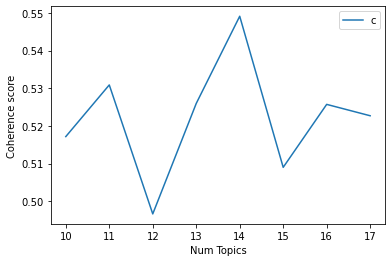

 [0] Num Topics = 10  has Coherence Value of 0.5172
 [1] Num Topics = 11  has Coherence Value of 0.5309
 [2] Num Topics = 12  has Coherence Value of 0.4966
 [3] Num Topics = 13  has Coherence Value of 0.5260
 [4] Num Topics = 14  has Coherence Value of 0.5491
 [5] Num Topics = 15  has Coherence Value of 0.5090
 [6] Num Topics = 16  has Coherence Value of 0.5257
 [7] Num Topics = 17  has Coherence Value of 0.5227


In [7]:
plot_coherences(start, limit, step, coherence_values)

In [8]:
# elegir
# idx_optimo = 4
idx_optimo = 4
optimal_model_a = model_list[idx_optimo]
optimal_ntopics_a = len(model_list[idx_optimo].get_topics())

In [9]:
df_topic_sents_keywords_a = format_topics_documents(ldamodel=optimal_model_a,
                                                  corpus=corpus, texts=data_lemmatized)

Main topic: 100%|█████████████████████████| 12467/12467 [02:23<00:00, 86.71it/s]


In [77]:
# Format
df_dominant_topic_a = df_topic_sents_keywords_a.reset_index()
df_dominant_topic_a.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']
df_dominant_topic_a

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,2.0,0.4881,"post_on, instagrama_post, view_this, post_shared, shared_by, by, ano, hijo, foto, famoso","[adamari_lopez, luchar, sobrepeso, montana_rusa, subir, bajo, actriz, presentadoro, vencio, cancer, mama, ahora, batalla, sobrepeso, vivir, plenitud, ademas, trabajar, salud, mental, sintio, afect..."
1,1,0.0,0.3122,"persona, paso, medida, comuna, salud, semana, hora, autoridad, cuarentena, plan","[intendente, paro, camionero, interrumpir, libre, circulacion, via, publica, delito, intendente, consultado, paro, camionero, afectar, punto, rutar, sur, manifesto, capital, ahora, problema, abast..."
2,2,9.0,0.4298,"millón, ano, estudio, mayor, explicar, acceder, sistema, empresa, tambien, mas","[dentro, dar, conocer, experiencia, usuario, navegar, consola, compartido, caracteristica, proximo, disenar, conectar, rapidamente, jugador, videojuego, vicepresidente, planificacion, gestion, pla..."
3,3,2.0,0.7350,"post_on, instagrama_post, view_this, post_shared, shared_by, by, ano, hijo, foto, famoso","[rafael_araneda, marcela_vacarezza, presentar, hijo, redes_social, animador, television, rafael_araneda, marcela_vacarezza, presentar, ultimas_hora, hijo, pequeno, adoptado, ano, tramit, confesar,..."
4,4,4.0,0.6317,"hacer, decir, ver, dar, mas, tambien, bien, querer, tener, creer","[padre, separar, parte, llegar, terraza, cafe, reunir yo, cliente, empece, ver, semana_pasado, padre, sentado, leer, mas, acercar yo, poner, pie, evitar, pensar, solo, extremadamente, alto, pareci..."
...,...,...,...,...,...
12462,12462,9.0,0.5047,"millón, ano, estudio, mayor, explicar, acceder, sistema, empresa, tambien, mas","[presentar, bajo, nivel, sustentabilidad, costero, fuerte, impacto, urbanizacion, fuerza, ejercido, zonas_costera, mundial, especialmente, bajo, paradigma, sostenibilidad, ambiental, existir, estu..."
12463,12463,4.0,0.3577,"hacer, decir, ver, dar, mas, tambien, bien, querer, tener, creer","[analisi, director, aumento, homicidio, director, general, refirio, aumento, homicidio, pai, proposito, resultado, entregado, institucion, marco, gestion, operativo, ano, pasado, respecto, espinos..."
12464,12464,4.0,0.4063,"hacer, decir, ver, dar, mas, tambien, bien, querer, tener, creer","[partar, desafio, vislumbrar, nuevo, director, director, planteado, renuncia, dar, razón, argumento, compartir, razón, argumento, consecuencia, aceptado, renuncia, decir, minuto, presidente, sebas..."
12465,12465,2.0,0.3713,"post_on, instagrama_post, view_this, post_shared, shared_by, by, ano, hijo, foto, famoso","[mes, tension, raquel_perero, lograr, acuerdo, divorcio, luego, ano, relacion, cantante, espanol, exesposa, raquel_perero, lograr, sellar, acuerdo, divorcio, medio, batalla, legal, parejo, llevar,..."


### Nos enfocaremos en las categorias que poseen menos noticias hasta el momento

del paso anterior:

```
                category 	count(*)
                
                
1-Mundo 	                    8609
9-Crimen_delitos_y_Justicia 	8213
3-Política_y_Conflictos 	    7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
```

In [74]:
get_df_keywords(optimal_model_a, optimal_ntopics_a)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,persona,colegio,post_on,nuevo,hacer,caso,mascota,color,region,millón,ano,hecho,politico,serie
1,paso,clase,instagrama_post,proyecto,decir,nuevo,esposa,diseno,comuna,ano,primero,carabinero,presidente,personaje
2,medida,presencial,view_this,nacional,ver,total,jugador,urbano,casos_activo,estudio,mujer,luego,derecho,actor
3,comuna,educacion,post_shared,proceso,dar,contagio,robo,marca,lago,mayor,mundo,caso,gobierno,estadounidense
4,salud,alumno,shared_by,social,mas,nivel,pueblos_originario,temperatura,biobio,explicar,nuevo,persona,ministro,temporada
5,semana,estudiante,by,trabajo,tambien,cifra,colo_colo,parque,nota_tabla_emol_tablaennoticia,acceder,vida,detenido,violencia,pelicula
6,hora,profesor,ano,desarrollo,bien,salud,pequena,incendio,rio,sistema,vez,encontrar,plebiscito,historia
7,autoridad,ano,hijo,recurso,querer,persona,futbol,gratuito,punta_arena,empresa,chileno,victima,diputado,estreno
8,cuarentena,nino,foto,presidente,tener,nacional,club,madera,tasa,tambien,gran,denuncia,partido,papel
9,plan,escuela,famoso,buscar,creer,región,listado,integracion,zona,mas,solo,interior,rechazo,produccion


In [78]:
important_topics = [2.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 13.0]
df_topics = df.copy()
mask = df_dominant_topic_a.Dominant_Topic.isin(important_topics)
df_topics = df_topics[mask.reindex(df_topics.index, fill_value=False)]
df_topics.drop(columns=['Dominant_Topic', 'Unnamed: 0'], inplace=True)
df_topics

,id,url,title,content,Keywords,text_list,category
0,7329456,https://www.meganoticias.cl/tendencias/320596-adamari-lopez-adelgaza-1ab.html,"Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja""","Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja"". La actriz y presentadora puertorriqueña Adamari López es una luchadora. Venció el cáncer de mama y ah...","post_on, instagrama_post, view_this, post_shared, shared_by, ano, by, hijo, hacer, vida","['adamari_lopez', 'luchar', 'sobrepeso', 'montana_rusa', 'subir', 'bajo', 'actriz', 'presentadoro', 'vencio', 'cancer', 'mama', 'ahora', 'batalla', 'sobrepeso', 'vivir', 'plenitud', 'ademas', 'tra...",NaN
2,6343140,https://www.latercera.com/que-pasa/noticia/asi-es-playstation-5-por-dentro-dan-a-conocer-la-experiencia-que-tendra-el-usuario-al-navegar-en-la-consola/RTWZGXDXRRG5FOALS3QMTEXVV4/,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola. Sony Interative Entertainment (SIE) ha compartido las características que tendrá la in...,"servicio, producto, persona, encontrar, usuario, sistema, contar, realizar, empresa, hora","['dentro', 'dar', 'conocer', 'experiencia', 'usuario', 'navegar', 'consola', 'compartido', 'caracteristica', 'proximo', 'disenar', 'conectar', 'rapidamente', 'jugador', 'videojuego', 'vicepresiden...",NaN
3,7355093,https://www.meganoticias.cl/tendencias/313371-rafael-araneda-y-marcela-vacarezza-presentaron-a-su-hijo-benjamin-rafael-adopcion-crx12.html,Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael,"Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael. En redes sociales, los animadores de televisión, Rafael Araneda y Marcela Vacarezza, presentaron en las últimas horas a su...","post_on, instagrama_post, view_this, post_shared, shared_by, ano, by, hijo, hacer, vida","['rafael_araneda', 'marcela_vacarezza', 'presentar', 'hijo', 'redes_social', 'animador', 'television', 'rafael_araneda', 'marcela_vacarezza', 'presentar', 'ultimas_hora', 'hijo', 'pequeno', 'adopt...",NaN
4,6321215,https://www.latercera.com/que-pasa/noticia/mis-padres-se-separaron-en-pandemia-que-hago-con-mi-papa-2-parte/HIWR4HNF25CADEYMWLZPAHW4LI/,Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte),"Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte). A las 11.59 llegué a la terraza de un café para reunirme con Benjamín, un cliente al que empecé a ver la semana pasada a raí...","hacer, decir, ver, creer, querer, gente, mas, persona, dar, tambien","['padre', 'separar', 'parte', 'llegar', 'terraza', 'cafe', 'reunir yo', 'cliente', 'empece', 'ver', 'semana_pasado', 'padre', 'sentado', 'leer', 'mas', 'acercar yo', 'poner', 'pie', 'evitar', 'pen...",NaN
7,97595,https://www.biobiochile.cl/noticias/nacional/chile/2020/10/29/ministro-desbordes-y-propuesta-de-j-a-kast-nos-trata-de-traidores-y-luego-habla-de-unidad.shtml,"Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad""","Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad"". El ministro de Defensa, Mario Desbordes, se refirió durante la mañana de este jueves a las opciones d...","hacer, decir, ver, creer, querer, gente, mas, persona, dar, tambien","['ministro', 'propuesto', 'tratar', 'traidor', 'luego', 'hablar', 'unidad', 'ministro', 'defensa', 'mario_desbord', 'refirio', 'jueves', 'opción', 'incorporar', 'partido_republicano', 'liderado', ...",NaN
...,...,...,...,...,...,...,...
12462,5165171,https://www.elciudadano.com/chile/el-90-del-area-de-la-bahia-de-concon-presenta-bajos-niveles-de-sustentabilidad-costera/09/04/,El 90% del área de la Bahía de Concón presenta bajos niveles de sustentabilidad costera,El 90% del área de la Bahía de Concón presenta 

### Repetimos el proceso anterior ahora para una cantidad mas acotada de topicos y con un mayor rango de busqueda de mejor coeherencia

In [79]:
# quitaremos algunas palabras que no entregan mucha informacion
stop_words = ['persona', 'post_on', 'instagrama_post', 'view_this', 'post_shared',
              'shared_by', 'by', 'ano', 'hacer', 'decir', 'ver', 'dar',
              'mas', 'tambien', 'bien', 'querer', 'tener', 'gente']

In [80]:
corpus, id2word, data_lemmatized = get_from_textlist(df_topics, stop_words=stop_words)
# un numero muy alto resulta en algunos topicos con muy pocas noticias (< 50)
limit=10; start=4; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start, limit=limit, step=step)

LDA MODELS: 100%|█████████████████████████████████| 1/1 [01:06<00:00, 66.79s/it]


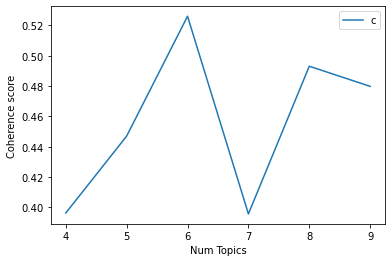

 [0] Num Topics = 4  has Coherence Value of 0.3963
 [1] Num Topics = 5  has Coherence Value of 0.4470
 [2] Num Topics = 6  has Coherence Value of 0.5261
 [3] Num Topics = 7  has Coherence Value of 0.3957
 [4] Num Topics = 8  has Coherence Value of 0.4931
 [5] Num Topics = 9  has Coherence Value of 0.4798


In [78]:
plot_coherences(start, limit, step, coherence_values)

In [81]:
idx_optimo = 2
optimal_model = model_list[idx_optimo]
optimal_ntopics = len(model_list[idx_optimo].get_topics())
df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model,
                                                  corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']
df_dominant_topic.head(10)

Main topic: 100%|██████████████████████████| 6309/6309 [00:47<00:00, 133.34it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,3.0,0.6171,"pasar, vida, mujer, vez, momento, ahora, hablar, siempre, cosa, solo","[adamari_lopez, luchar, sobrepeso, montana_rusa, subir, bajo, actriz, presentadoro, vencio, cancer, mama, ahora, batalla, sobrepeso, vivir, plenitud, ademas, trabajar, salud, mental, sintio, afect..."
1,1,2.0,0.6294,"estudio, solo, explicar, nuevo, encontrar, millón, producto, acceder, primero, uso","[dentro, dar, conocer, experiencia, usuario, navegar, consola, compartido, caracteristica, proximo, disenar, conectar, rapidamente, jugador, videojuego, vicepresidente, planificacion, gestion, pla..."
2,2,5.0,0.8025,"hijo, redes_social, nuevo, cantante, famoso, contar, primero, foto, video, actriz","[rafael_araneda, marcela_vacarezza, presentar, hijo, redes_social, animador, television, rafael_araneda, marcela_vacarezza, presentar, ultimas_hora, hijo, pequeno, adoptado, ano, tramit, confesar,..."
3,3,3.0,0.7859,"pasar, vida, mujer, vez, momento, ahora, hablar, siempre, cosa, solo","[padre, separar, parte, llegar, terraza, cafe, reunir yo, cliente, empece, ver, semana_pasado, padre, sentado, leer, mas, acercar yo, poner, pie, evitar, pensar, solo, extremadamente, alto, pareci..."
4,4,0.0,0.7432,"politico, presidente, cambio, creer, institucion, proceso, general, nuevo, parte, gobierno","[ministro, propuesto, tratar, traidor, luego, hablar, unidad, ministro, defensa, mario_desbord, refirio, jueves, opción, incorporar, partido_republicano, liderado, cara, eleccion, convencionales_c..."
5,5,5.0,0.8154,"hijo, redes_social, nuevo, cantante, famoso, contar, primero, foto, video, actriz","[power_peralta, presentar, hermana, menor, ano, sorprender, red, trav, redes_social, raul_peralto, presento, hermana, menor, emilia, recientemente, cumplio, ano, edad, tierno_mensaje, felicitación..."
6,6,3.0,0.4850,"pasar, vida, mujer, vez, momento, ahora, hablar, siempre, cosa, solo","[jugar, local, secuela, factor, campo, vacio, localiar, ventaja, equipo, conocimiento, campo, aliento, hincha, factor, historicamente, convertir, fortaleza, debilidad, visitante, viceversar, menos..."
7,7,5.0,0.6479,"hijo, redes_social, nuevo, cantante, famoso, contar, primero, foto, video, actriz","[reportero, guerrillero, haciar, actor, chavo, famoso, actor, serie, mexicano, reconocido, divertido, inolvidable, personaje, interpretar, sabiar, fama, llegaria, arte, actuacion, mayorio, dedicar..."
8,8,5.0,0.7298,"hijo, redes_social, nuevo, cantante, famoso, contar, primero, foto, video, actriz","[diós, atrevir, lucir, tonificado, figura, playa, programa, hungaro, demostro , ano, lucir, espectacular, figura, condicion, fisico, capaz, seguir, deslumbrar, publico, despedir, ano, actriz, vene..."
9,9,5.0,0.8032,"hijo, redes_social, nuevo, cantante, famoso, contar, primero, foto, video, actriz","[gigi_hadid, finalmente, revelar, forma, original, nombre, hija, mes, top, model, internacional, gigi_hadid, finalmente, revelo, nombre, largo, mes, mantener, expectativo, millón, fan, desear, con..."


In [82]:
df_dominant_topic['Dominant_Topic'].value_counts()

5.0    1994
2.0    1349
0.0    1322
3.0     838
4.0     655
1.0     151
Name: Dominant_Topic, dtype: int64

In [83]:
get_df_keywords(optimal_model, optimal_ntopics)

,0,1,2,3,4,5
0,politico,nota_tabla_emol_tablaennoticia,estudio,pasar,salud,hijo
1,presidente,tr_td,solo,vida,caso,redes_social
2,cambio,comuna,explicar,mujer,mes,nuevo
3,creer,casos_activo,nuevo,vez,medico,cantante
4,institucion,lago,encontrar,momento,mayor,famoso
5,proceso,biobio,millón,ahora,situacion,contar
6,general,lunes,producto,hablar,familia,primero
7,nuevo,común,acceder,siempre,medida,foto
8,parte,text_align,primero,cosa,nino,video
9,gobierno,height_px,uso,solo,colegio,actriz


### Analizamos las palabras claves y algunas noticias de cada topico

In [85]:
pd.set_option('display.max_colwidth', 200)
# por ejemplo vemos noticias del topico 4, posiblemente categoria salud
mask = df_dominant_topic['Dominant_Topic'] == 4
df_topics.reset_index()[mask][['id', 'content']]

,id,content
17,13488197,"25% de hogares que perdieron ingresos en pandemia sufre inseguridad alimentaria. La Encuesta Social Covid-19 midió entre otras cosas el nivel de inseguridad alimentaria, es decir, la incertidumbre..."
18,4793858,"Subsecretario Zúñiga: “Estamos muy preocupados con el nivel de contagios que están teniendo las comunas de Rancagua, Graneros y San Fernando”. Esta tarde, el subsecretario de Redes Asistenciales, ..."
19,6334269,"Violencia digital: Un 32% de niñas entre 12 a 14 años recibió peticiones sexuales o le pidieron fotografías íntimas. La violencia de género no distingue edad. Mujeres, niños, niñas y adolescentes ..."
24,4788034,"El 48% de los médicos del país atiende a pacientes de Fonasa por la vía de la compra de bonos. De acuerdo con la Superintendencia de Salud, en Chile hay 54.234 médicos registrados para ejercer su ..."
50,15703888,"La importancia de atenciones virtuales en pandemia y cómo se adaptaron a la crisis. $(function(){creaVideoDetalle(""https://tv.emol.com/detail/20200925135952261/la-importancia-de-atenciones-virtual..."
...,...,...
6266,167606,"Médicos de Magallanes indignados por minuta que los acusa de no hacer bien su trabajo en pandemia. Una minuta del Servicio de Salud de Magallanes, que llegó al nivel central del Ministerio de Salu..."
6267,9579,Acusan a una enfermera: Al menos 16 mujeres denuncian que les inyectaron silicona industrial. Al menos 16 mujeres denuncian que fueron estafadas por una ciudadana que decía ser enfermera y prometi...
6282,129360,"Según INE: 50% de las personas ocupadas en Los Lagos recibió ingresos menores a &#36;383.000 en el 2019. Según la encuesta suplementaria, entregada por el Instituto Nacional de Estadísticas (INE),..."
6285,6329947,El científico que calcula el Factor “R efectivo” para el Minsal: ¿Qué es y cómo ayuda a saber la rapidez con que se propaga una pandemia?. “Siempre que tomamos una decisión como Ministerio de Salu...


In [86]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# solo tomamos los que parecen acercarse mas a alguna de nuestras
# categorias
cats_dict = {0 : '3-Política_y_Conflictos',
             4 : '10-Salud',}

to_ignore = [1, 3]

for i in range(optimal_ntopics):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{0: '3-Política_y_Conflictos', 4: '10-Salud', 1: nan, 2: nan, 3: nan, 5: nan}

In [87]:
df_topics.reset_index(inplace=True)
df_topics['dominant_topic'] = df_dominant_topic['Dominant_Topic']
df_topics

,index,id,url,title,content,Keywords,text_list,category,dominant_topic
0,0,7329456,https://www.meganoticias.cl/tendencias/320596-adamari-lopez-adelgaza-1ab.html,"Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja""","Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja"". La actriz y presentadora puertorriqueña Adamari López es una luchadora. Venció el cáncer de mama y ah...","post_on, instagrama_post, view_this, post_shared, shared_by, ano, by, hijo, hacer, vida","['adamari_lopez', 'luchar', 'sobrepeso', 'montana_rusa', 'subir', 'bajo', 'actriz', 'presentadoro', 'vencio', 'cancer', 'mama', 'ahora', 'batalla', 'sobrepeso', 'vivir', 'plenitud', 'ademas', 'tra...",NaN,3.0
1,2,6343140,https://www.latercera.com/que-pasa/noticia/asi-es-playstation-5-por-dentro-dan-a-conocer-la-experiencia-que-tendra-el-usuario-al-navegar-en-la-consola/RTWZGXDXRRG5FOALS3QMTEXVV4/,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola. Sony Interative Entertainment (SIE) ha compartido las características que tendrá la in...,"servicio, producto, persona, encontrar, usuario, sistema, contar, realizar, empresa, hora","['dentro', 'dar', 'conocer', 'experiencia', 'usuario', 'navegar', 'consola', 'compartido', 'caracteristica', 'proximo', 'disenar', 'conectar', 'rapidamente', 'jugador', 'videojuego', 'vicepresiden...",NaN,2.0
2,3,7355093,https://www.meganoticias.cl/tendencias/313371-rafael-araneda-y-marcela-vacarezza-presentaron-a-su-hijo-benjamin-rafael-adopcion-crx12.html,Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael,"Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael. En redes sociales, los animadores de televisión, Rafael Araneda y Marcela Vacarezza, presentaron en las últimas horas a su...","post_on, instagrama_post, view_this, post_shared, shared_by, ano, by, hijo, hacer, vida","['rafael_araneda', 'marcela_vacarezza', 'presentar', 'hijo', 'redes_social', 'animador', 'television', 'rafael_araneda', 'marcela_vacarezza', 'presentar', 'ultimas_hora', 'hijo', 'pequeno', 'adopt...",NaN,5.0
3,4,6321215,https://www.latercera.com/que-pasa/noticia/mis-padres-se-separaron-en-pandemia-que-hago-con-mi-papa-2-parte/HIWR4HNF25CADEYMWLZPAHW4LI/,Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte),"Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte). A las 11.59 llegué a la terraza de un café para reunirme con Benjamín, un cliente al que empecé a ver la semana pasada a raí...","hacer, decir, ver, creer, querer, gente, mas, persona, dar, tambien","['padre', 'separar', 'parte', 'llegar', 'terraza', 'cafe', 'reunir yo', 'cliente', 'empece', 'ver', 'semana_pasado', 'padre', 'sentado', 'leer', 'mas', 'acercar yo', 'poner', 'pie', 'evitar', 'pen...",NaN,3.0
4,7,97595,https://www.biobiochile.cl/noticias/nacional/chile/2020/10/29/ministro-desbordes-y-propuesta-de-j-a-kast-nos-trata-de-traidores-y-luego-habla-de-unidad.shtml,"Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad""","Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad"". El ministro de Defensa, Mario Desbordes, se refirió durante la mañana de este jueves a las opciones d...","hacer, decir, ver, creer, querer, gente, mas, persona, dar, tambien","['ministro', 'propuesto', 'tratar', 'traidor', 'luego', 'hablar', 'unidad', 'ministro', 'defensa', 'mario_desbord', 'refirio', 'jueves', 'opción', 'incorporar', 'partido_republicano', 'liderado', ...",NaN,0.0
...,...,...,...,...,...,...,...,...,...
6304,12462,5165171,https://www.elciudadano.com/chile/el-90-del-area-de-la-bahia-de-concon-presenta-bajos-niveles-de-sustentabilidad-costera/09/04/,El 90% del área de la Bahía de Concón presenta bajos niveles de sustent

In [88]:
df_topics['category'] = df_topics.apply(lambda row : cats_dict[row.dominant_topic], axis=1)

### exportamos nuesta seleccion

In [89]:
file_idx = 1

In [90]:
# con categoria
_df = df_topics[df_topics.category.notna()][['id', 'title', 'content', 'category']]
_df.to_csv(f'categorias_{file_idx}_paso2.csv')
file_idx += 1

In [32]:
# los que requieren mas lda
for i in range(optimal_ntopics):
    # agregar solo los category == nan
    if not isinstance(cats_dict[i], str) and np.isnan(cats_dict[i]):
        if i not in to_ignore:
            sub_df = df_topics[df_topics['dominant_topic'] == i]
            sub_df = sub_df[['id', 'title', 'content', 'text_list']]
            sub_df.to_csv(f'./dominant_topics/topics_paso2_{i}.csv')

## Utilizando los topicos que guardamos previamente, realizaremos un análisis para determinar el número óptimo de subtópicos dentro del tópico en cuestión.

In [52]:
# todo lo de abajo se repite para los topicos seleccionados
# topics 2 y 5
TOPIC = 2

filename = f'./dominant_topics/topics_paso2_{TOPIC}.csv'
df = pd.read_csv(filename)
corpus, id2word, data_lemmatized = get_from_textlist(df, stop_words=stop_words)
# Can take a long time to run.
limit=13; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start, limit=limit, step=1)

LDA MODELS: 100%|███████████████████████████████| 11/11 [02:10<00:00, 11.88s/it]


### Grafico de subtopicos ideal (mayor es mejor)
* Considerando que queremos mejorar la precision de nuestro topico debemos aumentar la cantidad de topicos dentro de esta, por lo que optamos por análizar opciones entre 2 y 10 grupos.

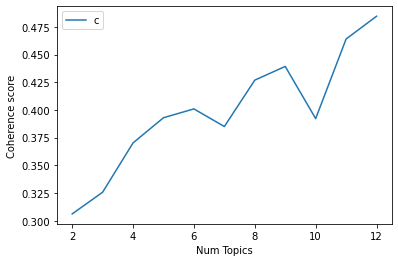

 [0] Num Topics = 2  has Coherence Value of 0.3061
 [1] Num Topics = 3  has Coherence Value of 0.3257
 [2] Num Topics = 4  has Coherence Value of 0.3703
 [3] Num Topics = 5  has Coherence Value of 0.3930
 [4] Num Topics = 6  has Coherence Value of 0.4009
 [5] Num Topics = 7  has Coherence Value of 0.3850
 [6] Num Topics = 8  has Coherence Value of 0.4269
 [7] Num Topics = 9  has Coherence Value of 0.4393
 [8] Num Topics = 10  has Coherence Value of 0.3922
 [9] Num Topics = 11  has Coherence Value of 0.4640
 [10] Num Topics = 12  has Coherence Value of 0.4846


In [53]:
plot_coherences(start, limit, step, coherence_values)

In [58]:
# elegir dependiendo de la coherencia y la cantidad de noticias por topico
# para evitar configuraciones que tienen topicos conmuy pocas noticias 
# topic 5 : idx_optimo = 4, topic 2 : idx_optimo = 4
idx_optimo = 4
optimal_model = model_list[idx_optimo]
optimal_ntopics = len(model_list[idx_optimo].get_topics())

In [59]:
df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model,
                                                  corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']

Main topic: 100%|██████████████████████████| 1349/1349 [00:07<00:00, 187.58it/s]


### Cantidad de noticias por topico

In [60]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    482
2.0    269
5.0    256
1.0    199
3.0    141
4.0      2
Name: Dominant_Topic, dtype: int64

### Ver los keywords de cada topico

Analizaremos de manera manual nuevamente los topicos generados, con la intención de volver a clasificarlos.


In [62]:
get_df_keywords(optimal_model, optimal_ntopics)

,0,1,2,3,4,5
0,nuevo,zona,solo,alimento,lote,producto
1,estudio,agua,espacio,salud,retiro,empresa
2,cientifico,especie,casa,dieta,dissimilar_cl,millón
3,vez,nacional,lugar,carne,anticonceptivo,nivel
4,planeta,riesgo,primero,producto,ancestral,ambiental
5,solo,encontrar,plastico,enfermedad,rosen,país
6,investigador,mar,contar,consumo,isp,mayor
7,primero,parte,llegar,mascota,elon_musk,aumento
8,tiempo,explicar,material,tratamiento,anulette_cd,uso
9,encontrar,sector,chileno,comer,instituto,proyecto


En este ejemplo podemos apreciar que las palabras claves sugieren que se trata de temas como farandula, espectaculos y redes sociales.

### Visibilizar las noticias de tópicos específicos

In [66]:
df[df_dominant_topic['Dominant_Topic'] == 5][['id', 'content']]

,id,content
4,6324489,"Pandemia dejará 1.500 millones de mascarillas usadas en los océanos del mundo. A fines de febrero, cuando la Organización Mundial de la Salud (OMS) aún no había declarado la pandemia y el primer c..."
7,13344174,"Sernac confirma que ha recibido 40 reclamos por ""eventual presencia de larvas"" en conocidas galletas. Preocupación ha generado en los consumidores las publicaciones realizadas en redes sociales qu..."
11,6534597,Pandemia desploma resultados de empresas estatales: Primera radiografía muestra caída en ingresos de hasta 60%. La crisis sanitaria del Covid-19 golpeó de lleno los resultados de las empresas esta...
13,4395884,"Jacinta Ardern declarará la próxima semana emergencia climática en Nueva Zelanda. El Gobierno de la primera ministra neozelandesa, Jacinda Ardern, declarará la semana que viene la emergencia climá..."
17,51420,"Ventas minoristas en la región de Valparaíso caen un 15,6% en tercer trimestre de 2020. Las ventas minoristas en la región de Valparaíso cayeron 15,6% en el trimestre comprendido entre julio y sep..."
...,...,...
1320,54153,"Falabella confirma que camión que trasladaba PlayStation 5 fue asaltado: se posterga entrega. Falabella confirmó que el camión que trasladaba las Playstation 5 sufrió un asalto, retrasando su entr..."
1326,25622,Incautan más de 3 mil kilos de marihuana en el Puerto de San Antonio: droga provenía de México. Un total de 3 mil 505 kilos de marihuana fueron incautados en un operativo llevado a cabo entre el S...
1340,6327484,Controversia: Estudio dice que una dieta sin carne no resolverá la crisis climática. Coma menos carne. Esa fue la tajante recomendación que realizó un informe de la ONU de 2019 sobre cambio climát...
1345,4422384,Trump bloqueará descargas de TikTok y WeChat en EE.UU. desde el domingo. El Departamento de Comercio de Estados Unidos tiene previsto emitir una orden el viernes que prohibirá la descarga en el pa...


# Trabajo manual

Al igual que al comienzo de nuestro trabajo, categorizamos de manera manual los topicos encontrados, en caso de que un topico no sea relevante, este no se agrega.

In [67]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""

# TOPIC = 5
# cats_dict = {4 : '6-Cultura_y_Artes'}

# TOPIC = 2 
cats_dict = {0 : '4-Ciencias_y_Tecnología',
            1 : '8-Ecología_y_Planeta',
            3 : '10-Salud'}

for i in range(optimal_ntopics):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{0: '4-Ciencias_y_Tecnología',
 1: '8-Ecología_y_Planeta',
 3: '10-Salud',
 2: nan,
 4: nan,
 5: nan}

Para TOPIC = 5 solo tomamos el subtopico 4, mientras que para TOPIC = 2 asignamos categorias a 3 subtopicos.

### Combinar el df inicial con el dataframe que contiene los subtopicos
Con esto podremos almacenar el dataframe con id, contenido de la noticia y la o las categorias recien asignadas

In [68]:
final_df = df.drop(columns=['text_list'])
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
final_df = pd.concat([final_df, df_dominant_topic[['Dominant_Topic', 'Keywords', 'text_list']]], axis=1)
final_df['Dominant_Topic'] = final_df['Dominant_Topic'].astype(int)

### Verificamos visualmente que el contenido coincida con text_list

In [69]:
final_df[['id', 'content', 'Dominant_Topic']]

,id,content,Dominant_Topic
0,6343140,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola. Sony Interative Entertainment (SIE) ha compartido las características que tendrá la in...,0
1,1384036,"118 colmillos de elefante fueron decomisados en Camerún. En total, 118 colmillos de elefante han sido decomisados en Ambam, sur de Camerún, un conocido centro de tráfico de marfil cerca de la fron...",0
2,6338378,WhatsApp podrá acceder a los mensajes de un chat si un usuario lo denuncia. WhatsApp ha introducido de forma limitada una función que permite a la compañía acceder a los mensajes de una conversaci...,0
3,6793921,"Plant based: La gloria vegetal. Elevación vegetal: MuuMami Casi como para gritarle ¡¿por qué no lo habías hecho antes?! A Rodolfo Guzmán, el destacado cocinero nacional, que en efecto pandemia lan...",2
4,6324489,"Pandemia dejará 1.500 millones de mascarillas usadas en los océanos del mundo. A fines de febrero, cuando la Organización Mundial de la Salud (OMS) aún no había declarado la pandemia y el primer c...",5
...,...,...,...
1344,1382471,"Boom de productos dermocosméticos para mascotas: ¿qué y cuándo usar?. El confinamiento por la pandemiaha estrechado los lazos entre seres humanos y animales domésticos. Tanto es así, que la cifras...",3
1345,4422384,Trump bloqueará descargas de TikTok y WeChat en EE.UU. desde el domingo. El Departamento de Comercio de Estados Unidos tiene previsto emitir una orden el viernes que prohibirá la descarga en el pa...,5
1346,6343365,Los humanos siguen evolucionando: una arteria del antebrazo revela que este proceso no se detiene. Un nuevo estudio muestra que nuestra especie todavía está evolucionando de formas únicas y los ca...,0
1347,13440601,"Cisne, Pavo Real, un toro y los pumas: Ahora rescatan Peuco en pleno Parque Forestal de Santiago. Un peuco fue encontrado merodeando esta mañana en el pleno Parque Forestal de Santiago , provoc...",1


### Guardamos solo los subtopicos que determinamos que tienen una categoria equivalente

In [70]:
final_df['category'] = final_df.apply(lambda row : cats_dict[row.Dominant_Topic], axis=1)

In [71]:
_df = final_df[final_df.category.notna()][['id', 'title', 'content', 'category']]
_df.to_csv(f'categorias_{file_idx}_paso2.csv')
file_idx += 1

In [72]:
_df[['content', 'category']]

,content,category
0,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola. Sony Interative Entertainment (SIE) ha compartido las características que tendrá la in...,4-Ciencias_y_Tecnología
1,"118 colmillos de elefante fueron decomisados en Camerún. En total, 118 colmillos de elefante han sido decomisados en Ambam, sur de Camerún, un conocido centro de tráfico de marfil cerca de la fron...",4-Ciencias_y_Tecnología
2,WhatsApp podrá acceder a los mensajes de un chat si un usuario lo denuncia. WhatsApp ha introducido de forma limitada una función que permite a la compañía acceder a los mensajes de una conversaci...,4-Ciencias_y_Tecnología
5,"Departamento de Astronomía UdeC hace llamado a planificación con seguridad para ver eclipse de sol. A menos de una semana que -a pleno mediodía- dejará a oscuras algunas zonas del país, desde el D...",4-Ciencias_y_Tecnología
6,Informe de la ONU: Cuatro regiones de Chile concentran desnutrición crónica infantil. Uno de cada cinco territorios de América Latina y el Caribe presenta rezagos en la desnutrición crónica infant...,8-Ecología_y_Planeta
...,...,...
1341,"Así puedes calcular la edad de tu perro. Durante toda la vida creímos que un año del perro son siete años humanos. Así podíamos decir que, si nuestra mascota tenía dos años, era para nosotros como...",4-Ciencias_y_Tecnología
1343,Informe ONU confirma que en los últimos 20 años se duplicó el número de desastres de origen natural en el mundo. En los últimos 20 años el mundo ha experimentado una serie de desastres de origen n...,8-Ecología_y_Planeta
1344,"Boom de productos dermocosméticos para mascotas: ¿qué y cuándo usar?. El confinamiento por la pandemiaha estrechado los lazos entre seres humanos y animales domésticos. Tanto es así, que la cifras...",10-Salud
1346,Los humanos siguen evolucionando: una arteria del antebrazo revela que este proceso no se detiene. Un nuevo estudio muestra que nuestra especie todavía está evolucionando de formas únicas y los ca...,4-Ciencias_y_Tecnología


Por supuesto, esta clasificacion no es perfecta, obteniendo algunas noticias con la asignacion de una categoria segundaria o netamente erronea, pero en general creemos que el resultado es mayormente positivo.

El proceso anterior se repite para los topicos o subtopicos que parezcan ser de utilidad y que no tengan una categoria asignada.